# Patch Prediction Models

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/05_example_patchpredictor.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/05_example_patchpredictor.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Colab"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

_If you are using google Colab, for faster responses you should enable the use of GPU for this session through (menu) Runtime ⟶ Change runtime type ⟶ Set "Hardware Accelator" to "GPU"._

# Welcome to tiatoolbox!

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right click on "Open in Colab" and select "Open in new tab" if left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.

### About this demo
In this example, we will show how to use tiatoolbox for patch-level prediction using a range of deep learning models. Tiatoolbox can be used to make predictions on pre-extracted image patches or on larger image tiles / whole-slide images (WSIs), where image patches are extracted on the fly. WSI patch-level predictions can subsequently be aggregated to obtain a segmentation map. In particular, we will introduce the use of our module
`patch_predictor` ([details](https://github.com/TIA-Lab/tiatoolbox/blob/master/tiatoolbox/models/classification/patch_predictor.py)). A full list of the available models trained and provided in tiatoolbox for patch-level prediction are given below.

- Models trained on the Kather 100k dataset ([details](https://zenodo.org/record/1214456#.YJw4UEhKjvU)):
    - `alexnet-kather100k`
    - `resnet18-kather100k`
    - `resnet34-kather100k`
    - `resnet50-kather100k`
    - `resnet101-kather100k`
    - `resnext50_32x4d-kather100k`
    - `resnext101_32x8d-kather100k`
    - `wide_resnet50_2-kather100k`
    - `wide_resnet101_2-kather100k`
    - `densenet121-kather100k`
    - `densenet161-kather100k`
    - `densenet169-kather100k`
    - `densenet201-kather100k`
    - `mobilenet_v2-kather100k`
    - `mobilenet_v3_large-kather100k`
    - `mobilenet_v3_small-kather100k`
    - `googlenet-kather100k`

### Setting up the environment
You can skip this cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [1]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip install --upgrade --ignore-installed --quiet git+https://github.com/TIA-Lab/tiatoolbox@enhance-example-patchpredction | tail -n 1

print('Installation is done.')

Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
tensorflow 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.0 which is incompatible.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompati

### Importing related libraries

We import some some standard Python modules, and also the Tiatoolbox Python modules for the patch classification task, written by the TIA Centre team.

In [2]:
from tiatoolbox.models.classification import CNNPatchPredictor
from tiatoolbox.models.dataset import PatchDataset
from tiatoolbox.utils.misc import imread, get_pretrained_model_info, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_patch_prediction
from tiatoolbox.wsicore.wsireader import get_wsireader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob

mpl.rcParams['figure.dpi'] = 160 # for high resolution figure in notebook

### Downloading the required files
We download, over the internet, image files used for the purpose of this notebook. In particular, we download a sample subset of validation patches that were used when training models on the Kather 100k dataset, a sample image tile and a sample whole-slide image. Downloading is needed once in each Colab session and it should take less than 1 minute.
> In Colab, if you click the files icon (see below) in the vertical toolbar on the left hand side then you can see all the files which the code in this notebook can access. The data will appear here when it is downloaded.
>
> 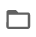

In [3]:
import requests

img_file_name = "sample_tile.png"
wsi_file_name = "sample_wsi.svs"

print('Download has started. Please wait...')

# Downloading sample image tile
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_imgs/CRC-Prim-HE-05_APPLICATION.tif")
with open(img_file_name, "wb") as f:
    f.write(r.content)

# Downloading sample whole-slide image
r = requests.get("https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs")
with open(wsi_file_name, "wb") as f:
    f.write(r.content)

# Use a tool called wget to download a sample of the validation set used to train the Kather 100K dataset
! wget https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
# Unzip it!
# (-o = overwrite if needed, -q = be quiet i.e. don't print out lots of unnecessary things)
! unzip -o -q kather100k-validation-sample.zip

print('Download is complete.')

Download has started. Please wait...
--2021-08-27 09:49:49--  https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip
Resolving tiatoolbox.dcs.warwick.ac.uk (tiatoolbox.dcs.warwick.ac.uk)... 137.205.117.139
Connecting to tiatoolbox.dcs.warwick.ac.uk (tiatoolbox.dcs.warwick.ac.uk)|137.205.117.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233532541 (223M) [application/zip]
Saving to: ‘kather100k-validation-sample.zip’

kather100k-validati 100%[===================>] 222.71M  29.0MB/s    in 8.2s    

2021-08-27 09:49:58 (27.1 MB/s) - ‘kather100k-validation-sample.zip’ saved [233532541/233532541]

Download is complete.


# Get predictions for a set of patches

Below we will demonstrate how to use tiatoolbox to obtain the model predictions for a set of patches with a pretrained model.

For this demonstration, we are going to use patches from the validation subset of [Kather 100k](https://zenodo.org/record/1214456#.YJ-tn3mSkuU) dataset. This dataset has already been downloaded in the download section above. To enable usage of the data in this notebook, we will first read the data and convert it to a suitable format. In particular, we will create a list of patches and a list of corresponding labels. For example, the first label in `label_list` will indicate the class of the first image patch in `patch_list`.

Class ID: 0 -- Class Name: BACK -- Number of images: 211
Class ID: 1 -- Class Name: NORM -- Number of images: 176
Class ID: 2 -- Class Name: DEB -- Number of images: 230
Class ID: 3 -- Class Name: TUM -- Number of images: 286
Class ID: 4 -- Class Name: ADI -- Number of images: 208
Class ID: 5 -- Class Name: MUC -- Number of images: 178
Class ID: 6 -- Class Name: MUS -- Number of images: 270
Class ID: 7 -- Class Name: STR -- Number of images: 209
Class ID: 8 -- Class Name: LYM -- Number of images: 232
Total number of patches: 2000


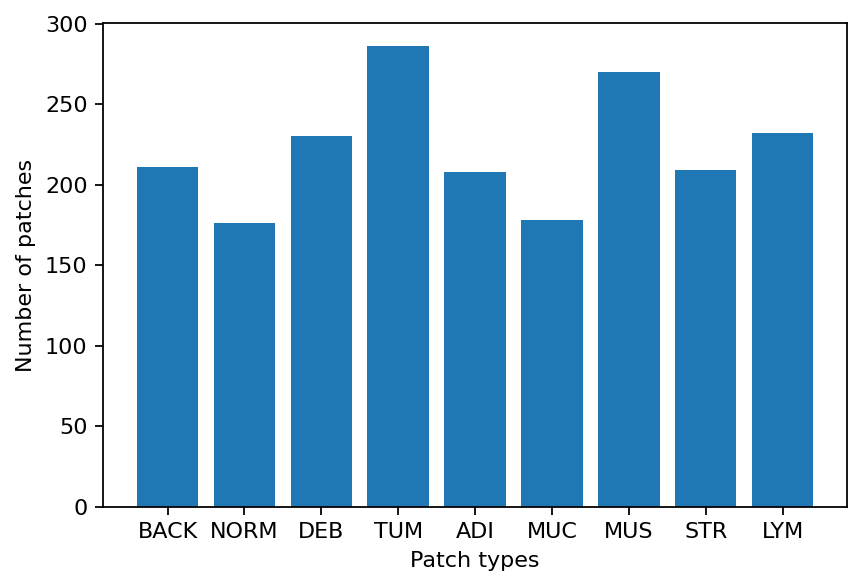

In [4]:
# read the patch data and create a list of patches and a list of corresponding labels

dataset_path = './kather100k-validation-sample/' # set the path to the dataset
image_ext = '.tif'  # file extention of each image

# obtain the mapping between the label ID and the class name
label_dict = {'BACK':0, 'NORM':1, 'DEB':2, 'TUM': 3, 'ADI':4, 'MUC':5, 'MUS':6, 'STR':7, 'LYM':8}
class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = os.path.join(dataset_path, class_name)
    patch_list_single_class = grab_files_from_dir(dataset_class_path, file_types='*'+image_ext)
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))


# show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel('Patch types')
plt.ylabel('Number of patches')

# count the number of examples per class
for class_name, label in label_dict.items():
    print('Class ID: {} -- Class Name: {} -- Number of images: {}'.format(
        label, class_name, label_list.count(label)
    ))
    
    
# overall dataset statistics
print('Total number of patches: {}'.format(len(patch_list)))

As you can see for this patch dataset, we have 9 classes/labels with IDs 0-8 and associated class names. describing the dominant tissue type in the patch:
- BACK ⟶ Background (empty glass region)
- LYM  ⟶ Lymphocytes
- NORM ⟶ Normal colon mucosa
- DEB  ⟶ Debris
- MUS  ⟶ Smooth muscle
- STR  ⟶ Cancer-associated stroma
- ADI  ⟶ Adipose
- MUC  ⟶ Mucus 
- TUM  ⟶ Colorectal adenocarcinoma epithelium

It is easy to use this code for your dataset - just ensure that your dataset is arranged like this example (images of different classes are placed into different subfolders), and set the right image extension in the `image_ext` variable. 

## Predict patch labels in 2 lines of code
Now that we have the list of images, we can use tiatoolbox's `CNNPatchPredictor` to predict their category. First, we instantiate a predictor object and then we call the `predict` method to get the results.

In [5]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=64)
output = predictor.predict(imgs=patch_list, mode='patch')

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pretrained.yml
Save to /root/.tiatoolbox/models/pretrained.yml


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

|2021-08-27|09:50:04.990| [WARNING] /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Download from https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth
Save to /root/.tiatoolbox/models/resnet18-kather100k.pth


100%|###########################################| 32/32 [00:16<00:00,  1.92it/s]


Patch Prediction is Done!

The first line creates a CNN-based patch classifier instance based on the passed arguments and prepares a CNN model (generate the network, download pretrained weights, etc.). The CNN model used in this predictor can be set using the `pretrained_model` argument. A complete list of supported pretrained classification models that have been trained on the Kather 100K dataset, is reported in the first section of this notebook example. `CNNPatchPredictor` also enables you to use your own pre-trained models for your specific classification application. In order to do that, you might need to change some input arguments to the `CNNPatchPredictor` as explained below:
- `model`: Use externally defined PyTorch model for prediction with weights already loaded. This is useful when you want to use your own pre-trained model on your specific data. The only constraint is that the input model should be of `torch.nn.Module` type i.e. generated using Pytorch.
- `pretrained_model `: You are already familiar with this argument. Using this argument, you tell tiatoolbox to use one of its pre-trained models for the prediction task. A complete list of pre-trained models can be found [here](https://github.com/TIA-Lab/tiatoolbox/blob/831bad8ef6ffcd060261b970a0af963ce6c83f63/tiatoolbox/models/classification/patch_predictor.py#L604). Note that if you pass a `model` argument to the class, then `CNNPatchPredictor` would use the input `model` and neglect `pretrained_model`. In this example, we used `resnet18-kather100K` which mean the model architecture is an 18 layer ResNet that has been trained Kather100k dataset.
- `pretrained_weight`: When you are using a `pretrained_model`, the corresponding pretrained weights will also be downloaded by default.  However, you can override with your own set of weights via the `pretrained_weight` argument.
- `batch_size`: Number of images fed into the model each time. Higher values for this parameter requires you to have a GPU with higher memory capacity (if you are using GPU for the computations). 


The second line in the snippet above calls the `predict` method to apply the CNN on the input patches and get the results. Here are some important `predict` input arguments and their descriptions:
- `mode`: Type of input to be processed. Choose from either `patch`, `tile` or `wsi` based on your application. In this first example, we are predicting the tissue type of histology patches so we used the `patch` option. We will explain the use of `tile` and `wsi` options in the next sections.
- `imgs`: List of inputs to be processed. When using `patch` mode, the input must be either a list of images, a list of image file paths or a numpy array of an image list. 
- `return_probabilities`: If you would like to have per-class probabilities alongside predicted labels of input patches, you should set this option as true.

In the `patch` prediction mode, the `predict` method returns an output dictionary that contains the `predictions` (predicted labels) and `probabilities` (probability of each patch belonging to each class).

The cell below uses common python tools to visualize the patch classification results in terms of classification accuracy and confusion matrix.

Classification accuracy: 0.993


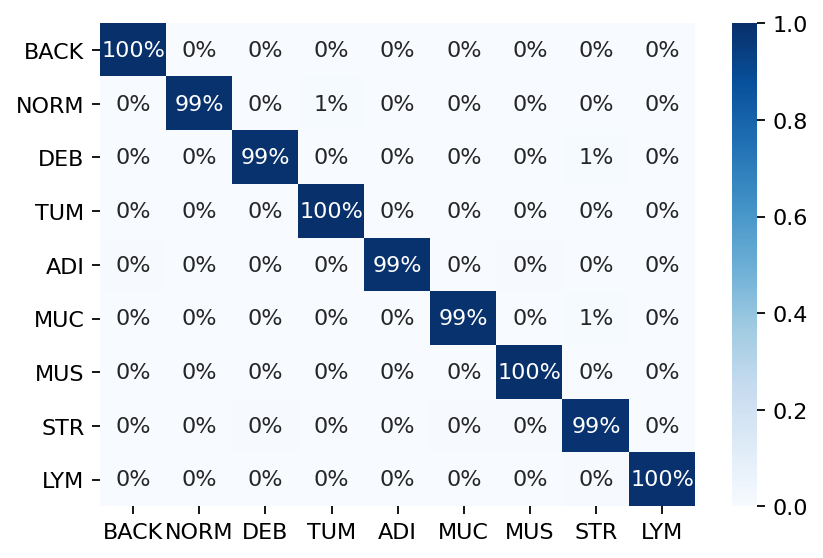

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

acc = accuracy_score(label_list, output['predictions'])
print('Classification accuracy: {}'.format(acc))

# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output['predictions'], normalize='true')
df_cm = pd.DataFrame(conf, index = class_names, columns = class_names)

# show confusion matrix
sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.0%')
plt.show()

Now, you can try changing the `pretrained_model` argument when making `CNNPatchPredictor` instant and see how it can affect the classification output accuracy.

# Get predictions for patches within an image tile

We will now demonstrate how to obtain patch-level predictions for a large image tile. It is quite a common practice in computational pathology to divide a large image into several patches (often overlapping) and then aggregate the results to generate a prediction map for different regions of the large image. As we are making a prediction per patch again, there is no need to instantiate a new `CNNPatchPredictor` class. However, we should tune the `predict` input arguments to make it suitable for tile prediction. The `predict` function then automatically extract patches from the large image tile and predicts the label for each of them. As the `predict` function can accept multiple tiles in the input to be processed and each input tile has potentially many patches, we save results as a file when more than one image is provided. This is done to avoid any problems with limited computer memory. However, if just one image is provided, then the results will be returned in the same way that is done for `patch` mode.

Now, let's try this function on a sample image tile. For this example, we use a tile that was released with the [Kather et al. 2016](https://doi.org/10.1038/srep27988) paper. It has been already downloaded in the Download section of this notebook.

Let's take look at it.

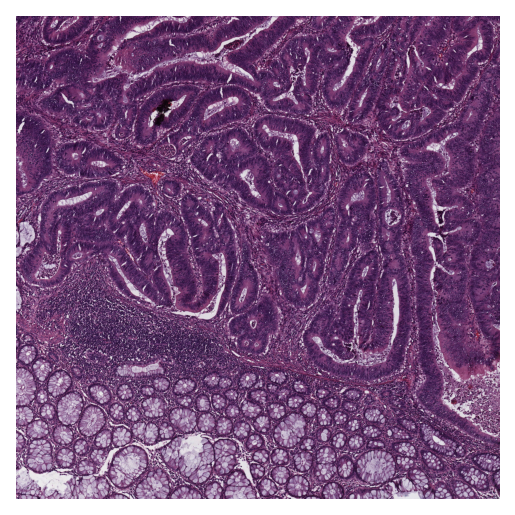

Tile size is: (5000, 5000, 3)


In [7]:
# reading and showing in the tile image
input_tile = imread(img_file_name)

plt.imshow(input_tile)
plt.axis('off')
plt.show()

print('Tile size is: {}'.format(input_tile.shape))

## Patch-level prediction for big histology tiles in 2 lines of code
As you can see, the size of the tile image is 5000x5000 pixels that is quite big and may results in computer memory problems if fed directly into a deep learning model. However, the `predict` method of `CNNPatchPredictor` handles this big tile seamlessly by processing small patches independently. You only need to change the `mode` argument to `tile` and a couple of other arguments, which will be explained shortly.

In [8]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=64)
tile_output = predictor.predict(imgs=[img_file_name], mode='tile',
                                stride_size=[56,56], return_probabilities=True)

|2021-08-27|09:50:30.744| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/dataset/classification.py:232: UserWarning: WSIPatchDataset only reads image tile at `units="baseline"` and `resolution=1.0`.
  "WSIPatchDataset only reads image tile at "

|2021-08-27|09:50:31.486| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:155: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

100%|#############################################| 9/9 [00:03<00:00,  2.69it/s]


The new arguments in the input of `predict` method are:
- `mode='tile'`: Determines the type of image input to make a prediction for. Here, we naturally use `tile` as our input is a large image tile. 
- `imgs`: _Note that_ in tile mode, the input can only be a list of file paths.
- `save_dir`:  Output directory when processing multiple tiles. We explained before why this is necessary when we are working on multiple big tiles.
- `patch_size`: This parameter sets the size of patches (in [W, H] format) to be extracted from the input tiles for which the labels will be predicted.
- `stride_size`: The stride (in [W, H] format) to consider when extracting patches from the tile. Using a stride smaller than the patch size results in overlapping between consecutive patches.
- `labels` (optional): List of labels with the same size as `imgs` that refers to the labels of input tiles as a whole (not to be confused with the prediction of each patch).

In this example, we used only one tile in the input therefore the toolbox does not save the output as files and instead return a list that contains output dictionary with the following keys:
- `coordinates`: List of extract patches' coordinates in the following format: `[x_min, y_min, x_max, y_max]`. These coordinates can be used to extract the same region from the input tile/WSI or regenerate a prediction map based on the `prediction` labels for each patch.
- `predictions`: List of predicted labels for each of the tile's patches.
- `label`: Label of the tile generalized to each patch.

Keep in mind that if we had several items in the `imgs` input, then the real result would be saved in JSON format at the specified `save_dir` and the returned output will be a list of paths to each of the saved JSON files.

Now, let's try and visualize some patch-level results:

### Visualisation of tile results

Below we will show some of the results generated by our patch-level predictor on the input image tile. First, we will show some individual patch predictions and then we will show the merged patch level results on the entire image tile.

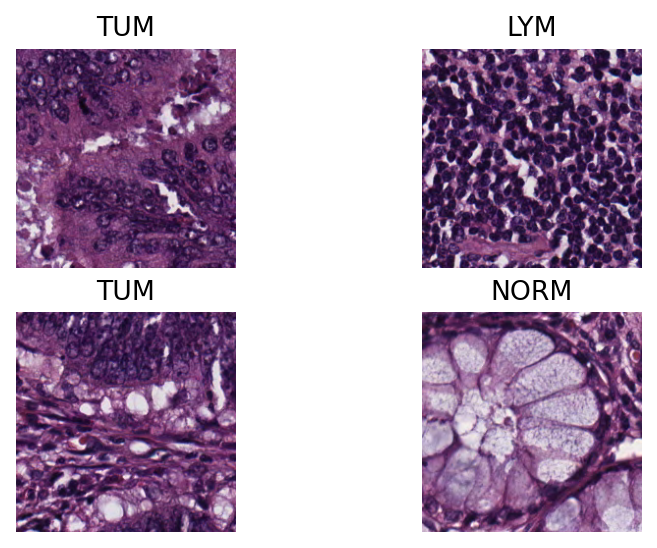

In [9]:
# individual patch predictions sampled from the image tile

# extract the information from output dictionary
coordinates = tile_output[0]['coordinates']
predictions = tile_output[0]['predictions']

# select 4 random index (patches) to show
random_idx = np.random.randint(0 , len(predictions), (4,))

for i, idx in enumerate(random_idx):
  this_coord = coordinates[idx]
  this_prediction = predictions[idx]
  this_class = class_names[this_prediction]

  this_patch = input_tile[this_coord[1]: this_coord[3], this_coord[0]: this_coord[2]]
  plt.subplot(2,2,i+1), plt.imshow(this_patch)
  plt.axis('off')
  plt.title(this_class)

Here, we will show a prediction map where each colour denotes a different predicted category and an overlay of the prediction map on to the original image. To generate this prediction map, we utilize the `merge_predictions` method from `CNNPatchPredictor` class which accepts the path of the original image, `predictor` outputs, `mode` (set to `tile` or `wsi`), `tile_resolution` (which is the resolution that tiles were originally extracted from) and `resolution` (which is the resolution at which the prediction map is generated) arguments and outputs the "Prediction map", in which regions have indexed values based on their classes.

To visualize the prediction map as an overlay on the input image, we can use `overlay_patch_prediction` function from `tiatoolbox.utils.visualization` module. It accepts the original image, the prediction map, `alpha` parameter which specifies the blending ratio of overlay and original image, and `label_info` dictionary which should contain names and desired colours for different classes. Below is an example of generating an acceptable `label_info` dictionary and how it can be used with `overlay_patch_prediction`.

|2021-08-20|11:07:54.984| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/models/classification/patch_predictor.py:259: UserWarning: Image is not pyramidal hence read is forced to be at `units='baseline'` and `resolution=1.0`.
  "at `units='baseline'` and `resolution=1.0`.",

|2021-08-20|11:07:54.985| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:155: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2021-08-20|11:07:54.986| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsimeta.py:158: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_power or mpp)")



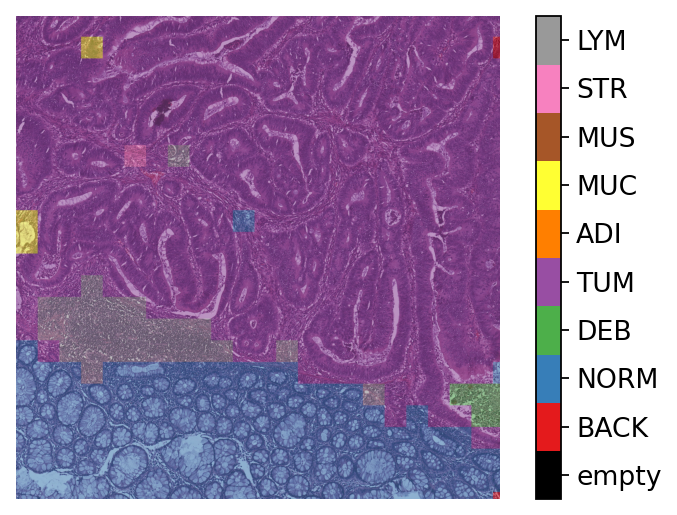

In [ ]:
# visualization of merged image tile patch-level prediction.
from matplotlib import cm

tile_output[0]['resolution']=1.0
tile_output[0]['units']='baseline'

label_color_dict = {}
label_color_dict[0] = ('empty', (0,0,0))
colors = cm.get_cmap('Set1').colors
for class_name, label in label_dict.items():
    label_color_dict[label+1] = (class_name, 255*np.array(colors[label]))
pred_map = predictor.merge_predictions(img_file_name, tile_output[0], resolution=1, units='baseline')
overlay = overlay_patch_prediction(input_tile, pred_map, alpha=0.5, label_info=label_color_dict)
plt.show()


Remember that `overlay_patch_prediction` returns a figure handler, and you only need to call `plt.show()` or `plt.savefig()` to show or save the generate overlay figure.
You can now go back and try predicting with a different `stride_size` or `pretrained_model` to see what effect this has on the output.

# Get predictions for patches within a WSI

We will now demonstrate how to obtain predictions for all patches within a whole-slide image. Similar to the previous sections, we will use `CNNPatchPredictor` and its `predict` method, but this time we set the `mode` to `wsi`, as below (here we use a quite large WSI and the patch extraction and prediction processes would take some time):

In [ ]:
predictor = CNNPatchPredictor(pretrained_model='resnet18-kather100k', batch_size=64)
wsi_output = predictor.predict([wsi_file_name],
                           mode='wsi',
                           patch_size=(224, 224),
                           stride_size=(224,224),
                           resolution=1,
                           units='baseline',
                           return_probabilities=True)

|2021-08-20|11:08:02.397| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:241: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."

100%|#######################################| 1136/1136 [07:59<00:00,  2.37it/s]


There are some new arguments introduced in the `predict` method, which are:
- `mode`: should be set to 'wsi' when analysing whole slide images.
- `resolution` and `unit`: These arguments specify the level or micron-per-pixel resolution of the WSI levels from which we plan to extract patches. Here we specify the WSI's level to "baseline" which is equivalent to level 0. In general, this is the level of greatest resolution, although, in this particular case, the image has only one level. More information can be found in the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader.WSIReader.read_rect). 
- `masks`: A list of paths correspond to the masks of WSIs in the `imgs`. These masks specify the regions in the original WSIs that we desire to extract patches from. If a `None` value is passed for a WSI, then the labels for all patches of that WSI (even background regions) would be predicted, which may cause unnecessary computational overhead when working on whole slide images.

Now, let's see how that prediction model worked on our input whole-slide images by visualizing the `wsi_output`. We first need to merge patch prediction outputs and then visualize it as an overlay on the original image. As before, the `merge_predictions` method is used to merge the patch predictions, however, note that here we set the parameters `resolution=1.25, units="power"` to generate the prediction map at 1.25x magnification. If you would like to have higher/lower resolution (bigger/smaller) prediction maps, you need
to change these parameters accordingly. When the predictions are merged, you can use the `overlay_patch_prediction` function to overlay that prediction map on the WSI thumbnail, which should be extracted at the same resolution that we used for prediction merging. Below you can see how the whole process works:

|2021-08-20|11:19:27.037| [WARNING] /usr/local/lib/python3.7/dist-packages/tiatoolbox/wsicore/wsireader.py:241: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



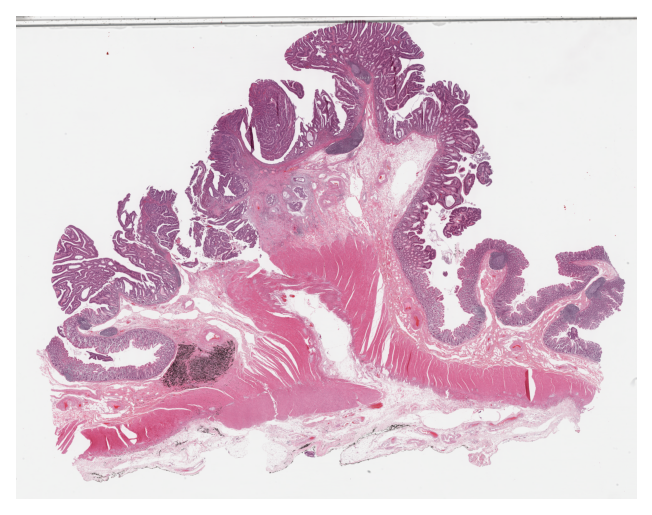

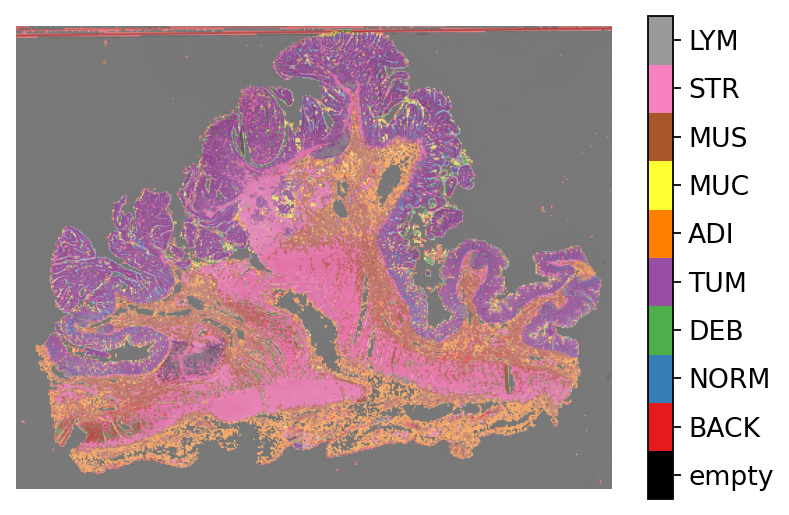

In [ ]:
# visualization of whole-slide image patch-level prediction
overview_resolution = 1.25 # the resolution in which we desire to merge and visualize the patch predictions
overview_unit = "power" # the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
wsi = get_wsireader(wsi_file_name)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview); plt.axis('off')

pred_map = predictor.merge_predictions(wsi_file_name, wsi_output[0], resolution=overview_resolution, units=overview_unit)
overlay = overlay_patch_prediction(wsi_overview, pred_map, alpha=0.5, label_info=label_color_dict)
plt.show()

In this example notebook, you saw how you can use the `CNNPatchPredictor` class and its `predict` method to predict the label for patches of big tiles and WSIs. Also, we introduced `merge_predictions` and `overlay_patch_prediction` helper functions that merge the patch prediction outputs as a prediction map and visualize that prediction map as an overlay on the input image/WSI, respectively.

All the processes are being done within the tiatoolbox and you don't need to code for anything. Just make sure that you have set the right input and options. We encourage you to further investigate the effect of changing `predict` function parameters on the prediction output in this notebook. 